### 라이브러리 로드

In [119]:
import numpy as np 
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPool2D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import cv2

import warnings
warnings.filterwarnings(action='ignore')

## Simple EDA

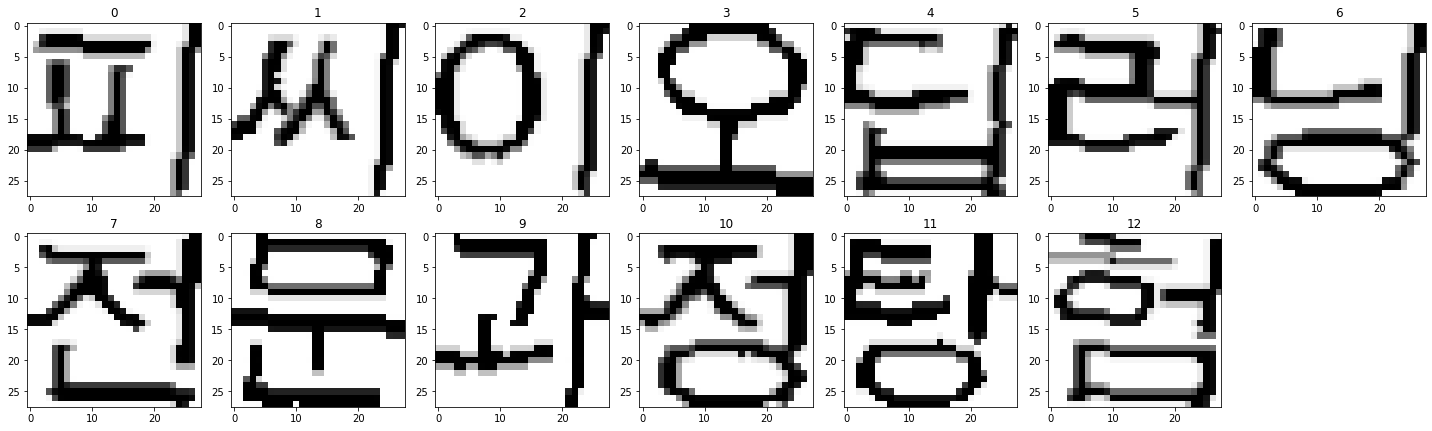

In [120]:
axes = []
fig = plt.figure(figsize=(20,6))
for i in range (13):
    axes.append(fig.add_subplot(2,7,i+1))
    subplot_title = str(i)
    axes[-1].set_title(subplot_title)
    img = Image.open('../input/pceo-mnist/train/'+str(i)+'/'+'G_0_0_0_0_0.png')
    plt.imshow(img)
fig.tight_layout()
plt.show()

### 데이터 전처리

In [121]:
sample_submission = pd.read_csv('../input/pceo-mnist/sample_submission.csv')
sample_submission.head()

,file_index,class
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [122]:
train_dir = '../input/pceo-mnist/train'
test_dir = '../input/pceo-mnist/test'
n_classes = 13
class_label = [i for i in range (n_classes)]
target_size = (28,28)
target_dim = (28,28,3)
val_size = 0.2
batch_size = 64

In [123]:
data_augmentor = ImageDataGenerator(samplewise_center=True, 
                                    samplewise_std_normalization=True, 
                                    validation_split=val_size,

                                    zoom_range=0.2,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2)
                                    
test_data_augmentor = ImageDataGenerator(samplewise_center=True, 
                                    samplewise_std_normalization=True)

train_generator = data_augmentor.flow_from_directory(train_dir, target_size=target_size, batch_size=batch_size, shuffle=True, subset="training")
val_generator = data_augmentor.flow_from_directory(train_dir, target_size=target_size, batch_size=batch_size, subset="validation")
test_generator = test_data_augmentor.flow_from_directory(test_dir, target_size=target_size, batch_size=batch_size, shuffle=False)

Found 17753 images belonging to 13 classes.
Found 4433 images belonging to 13 classes.
Found 6243 images belonging to 1 classes.


In [124]:
from tensorflow.keras.callbacks import EarlyStopping
 
early_stopping = EarlyStopping(
     min_delta = 0.0007,
     patience = 5,
     restore_best_weights=True
)

### 모델링 및 훈련

In [125]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(5,5), activation='relu', input_shape=target_dim))
model.add(MaxPool2D(pool_size=2,strides=1,padding="same"))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(256, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 24, 24, 32)        2432      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 22, 22, 64)        18496     
                                                                 
 flatten_6 (Flatten)         (None, 30976)             0         
                                                                 
 dense_18 (Dense)            (None, 512)               15860224  
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                      

In [126]:
model.compile(optimizer='Adagrad', loss='categorical_crossentropy', metrics=["accuracy"])

In [127]:
model.fit_generator(train_generator, epochs=30, validation_data = val_generator, callbacks=[early_stopping])

Epoch 1/30
278/278 [==============================] - 40s 142ms/step - loss: 1.9488 - accuracy: 0.3727 - val_loss: 1.2942 - val_accuracy: 0.5890
Epoch 2/30
278/278 [==============================] - 41s 146ms/step - loss: 0.9759 - accuracy: 0.6951 - val_loss: 0.6399 - val_accuracy: 0.8297
Epoch 3/30
278/278 [==============================] - 45s 161ms/step - loss: 0.5595 - accuracy: 0.8308 - val_loss: 0.4132 - val_accuracy: 0.8877
Epoch 4/30
278/278 [==============================] - 48s 172ms/step - loss: 0.3977 - accuracy: 0.8806 - val_loss: 0.2954 - val_accuracy: 0.9233
Epoch 5/30
278/278 [==============================] - 47s 169ms/step - loss: 0.2984 - accuracy: 0.9126 - val_loss: 0.2299 - val_accuracy: 0.9377
Epoch 6/30
278/278 [==============================] - 45s 163ms/step - loss: 0.2433 - accuracy: 0.9307 - val_loss: 0.2027 - val_accuracy: 0.9461
Epoch 7/30
278/278 [==============================] - 45s 162ms/step - loss: 0.2048 - accuracy: 0.9405 - val_loss: 0.1586 - val_ac

### Predict 및 Submission

submission을 위한 부분을 변경하지 말아주세요. 아래 코드로 실행하여 submission 파일을 만들어야 올바르게 채점할 수 있습니다. 

In [128]:
test_generator.reset()
predict = model.predict_generator(test_generator)
result = np.argmax(predict, axis=1)

In [129]:
submission = sample_submission.copy()
for i in range(len(submission)):
    submission.iloc[i,0] = str(submission.iloc[i,0])
submission = submission.sort_values('file_index')

In [130]:
class_map = train_generator.class_indices

In [131]:
submission = submission.reset_index()
for i in range(len(submission)):
    submission.iloc[i,-1] = list(class_map.keys())[list(class_map.values()).index(result[i])]
submission = submission.drop('index', axis=1)

In [132]:
submission.head()

,file_index,class
0,0,1
1,1,2
2,10,5
3,100,12
4,1000,6


In [133]:
submission.to_csv('submission.csv', index=False)